# Creating and Valuing a CDS Option

Example CDS Valuation and comparison with market standard ISDA model on Markit website

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from financepy.utils import *
from financepy.products.rates import *
from financepy.products.credit import *

####################################################################
# FINANCEPY BETA Version 0.33 - This build:  11 Nov 2023 at 07:47 #
#     This software is distributed FREE AND WITHOUT ANY WARRANTY   #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



Set the trade date and settlement date one day later

In [3]:
value_date = Date(5, 2, 2014)
settle_date = value_date.add_days(1)

## Build Ibor Curve

In [4]:
dcType = DayCountTypes.THIRTY_E_360
depo = IborDeposit(settle_date, "1D", 0.0502, dcType)
depos = [depo]
fixedFreq = FrequencyTypes.SEMI_ANNUAL
swapType = SwapTypes.PAY
swap1 = IborSwap(settle_date,"1Y",swapType,0.0502,fixedFreq,dcType)
swap2 = IborSwap(settle_date,"2Y",swapType,0.0502,fixedFreq,dcType)
swap3 = IborSwap(settle_date,"3Y",swapType,0.0501,fixedFreq,dcType)
swap4 = IborSwap(settle_date,"4Y",swapType,0.0502,fixedFreq,dcType)
swap5 = IborSwap(settle_date,"5Y",swapType,0.0501,fixedFreq,dcType)
swaps = [swap1,swap2,swap3,swap4,swap5]

libor_curve = IborSingleCurve(value_date, depos, [], swaps)

## Build a CDS Curve

In [5]:
cdsFlatSpread = 0.0100

In [6]:
cds1 = CDS(settle_date, "1Y", cdsFlatSpread)
cds2 = CDS(settle_date, "2Y", cdsFlatSpread)
cds3 = CDS(settle_date, "3Y", cdsFlatSpread)
cds4 = CDS(settle_date, "4Y", cdsFlatSpread)
cds5 = CDS(settle_date, "5Y", cdsFlatSpread)
cds6 = CDS(settle_date, "7Y", cdsFlatSpread)
cds7 = CDS(settle_date, "10Y", cdsFlatSpread)
cds8 = CDS(settle_date, "15Y", cdsFlatSpread)

In [7]:
cdss = [cds1, cds2, cds3, cds4, cds5, cds6, cds7, cds8]

In [8]:
recovery_rate = 0.40

In [9]:
issuer_curve = CDSCurve(value_date, cdss, libor_curve, recovery_rate)

## CDS Option

In [10]:
step_in_date = value_date.add_days(1)
expiry_date = Date(20, 3, 2014)
maturity_date = Date(20, 6, 2019)    

In [11]:
cds_coupon = 0.01
volatility = 0.3    
notional = ONE_MILLION
long_protection = True

In [12]:
strikes = np.linspace(80,120,21)/10000
longValues = []
shortValues = []

# Long Protection
for strike in strikes:
    cdsOption = CDSOption(expiry_date, maturity_date, strike, notional, True)
    v = cdsOption.value(value_date, issuer_curve, volatility)
    longValues.append(v)
    
# Short Protection
for strike in strikes:
    cdsOption = CDSOption(expiry_date, maturity_date, strike, notional, False)
    v = cdsOption.value(value_date, issuer_curve, volatility)
    shortValues.append(v)
    

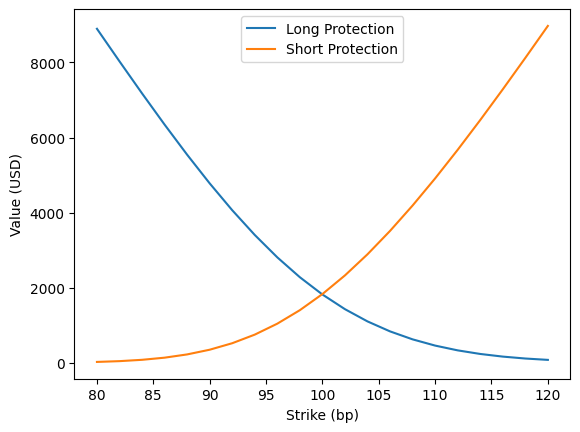

In [13]:
plt.plot(strikes*10000, longValues, label="Long Protection")
plt.plot(strikes*10000, shortValues, label="Short Protection")
plt.xlabel("Strike (bp)")
plt.ylabel("Value (USD)")
plt.legend();

## Put Call Parity

Check that put-call parity holds by comparing a long protection minus a short protection option to a forward starting long protection CDS

In [14]:
fwdValues = []

for strike in strikes:
    fwdCDSContract = CDS(expiry_date, maturity_date, strike, notional, True)
    v = fwdCDSContract.value(value_date, issuer_curve, recovery_rate)
    fwdValues.append(v['dirty_pv'])

In [15]:
callMinusPut = np.array(longValues) - np.array(shortValues)

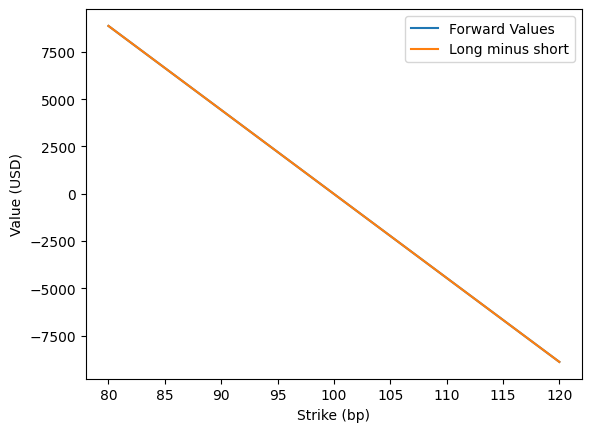

In [16]:
plt.plot(strikes*10000, fwdValues, label="Forward Values")
plt.plot(strikes*10000, callMinusPut, label="Long minus short")
plt.xlabel("Strike (bp)")
plt.ylabel("Value (USD)")
plt.legend();

## Implied Volatility

Let us just check that we can recover the input volatility

In [17]:
for strike in np.linspace(100, 200, 21):
    cdsOption = CDSOption(expiry_date, maturity_date, strike / 10000.0,  notional, False)
    v = cdsOption.value(value_date, issuer_curve, volatility)
    vol = cdsOption.implied_volatility(value_date, issuer_curve, v)
    print("%10d %12.5f %12.8f%%" %(strike, v, vol*100))

       100   1829.55743  30.00000000%
       105   3193.75808  30.00000000%
       110   4911.11646  30.00000000%
       115   6871.65771  30.00000000%
       120   8973.35932  30.00000000%
       125  11145.62429  30.00000000%
       130  13348.83063  30.00000000%
       135  15564.12776  30.00000000%
       140  17783.69318  30.00000000%
       145  20004.63617  30.00000000%
       150  22225.98988  30.00000000%
       155  24447.45776  30.00000000%
       160  26668.95546  30.00000000%
       165  28890.46054  30.00000000%
       170  31111.96736  30.00000000%
       175  33333.47457  30.00000000%
       180  35554.98186  30.00000000%
       185  37776.48917  30.00000000%
       190  39997.99649  30.00000000%
       195  42219.50381  30.00000000%
       200  44441.01112  30.00000000%


We recovery the used volatility as required.

Copyright (c) 2020 Dominic O'Kane